+ 虽然作业是完成了，但是神经网络还是不是很明白，尤其是反向传播算法，而且我的反向传播算法运行很慢，这不正常，视频上说是梯度检查慢（这个也确实慢），但是反向传播算法感觉不应该这么慢。之后跑一遍参考答案的代码看速度怎么样。
+ 在看了参考答案之后，反向传播算法的 step 1给稍微优化了一下，但是速度并没感觉有提升（理论上肯定比原来快，只是幅度应该没那么大）。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as scio

# 1 Neural Networks

## 1.1  Visualizing the data

((5000, 400), (5000, 10))

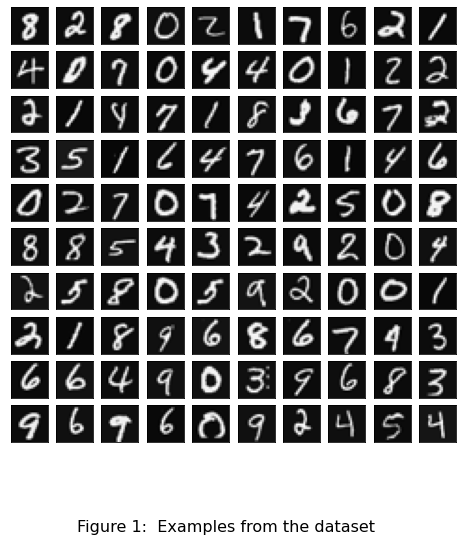

In [2]:
fpath = 'ex4data1.mat'
def displayData(fpath):
    data = scio.loadmat(fpath)
    X = np.array(data['X'])
    y = np.array(data['y'])
    m,n = X.shape

    # 随机显示的这 100 个只是单纯的看一下，后续不会对这100个进行什么操作的，所以就不返回了，看看就行了
    fig,ax_array = plt.subplots(nrows=10,ncols=10,sharex=True,sharey=True,figsize=(8,8))
    for i in range(100):
        r = i // 10
        c = i - r * 10   

        selected = np.random.randint(0,m)
        img = X[selected,:]
        img = img.reshape(20,20).T
        
        ax_array[r,c].imshow(img,cmap='gray')
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    fig.suptitle("Figure 1:  Examples from the dataset",fontsize=16,y = -0.01)
    
    
    # 处理 y，将每一个 y 由值 -> 向量，并且每个向量前移动一位
    # 题中还要求想让 K 支持任意的，但是这里我还是把它给写死了，原因在于如果label不是数字而是其他字符，那我该怎么映射？
    # 虽然脑子中这种的思路，比如强行用数字去映射label，然后数字的个数就是label的种类。但是不清楚是否真的是这样做，所以先空下这个要求。
    Y = np.zeros(shape=(m,10))
    for i in range(m): Y[i,(y[i,0] + 9)%10] = 1

    return X,Y
X,Y = displayData(fpath)
X.shape,Y.shape

# 1.2 Model representation

In [3]:
fpath = 'ex4weights.mat'
def loadTheta(fpath):
    thetas = scio.loadmat(fpath)
    return np.array(thetas['Theta1']).T,np.array(thetas['Theta2']).T
Theta1,Theta2 = loadTheta(fpath)
Theta1.shape,Theta2.shape

((401, 25), (26, 10))

In [4]:
def serialization(a,b):
    return np.concatenate((a.ravel(),b.ravel()))
def deSerialization(thetas):
    Theta1 = thetas[:401*25].copy()
    Theta2 = thetas[401*25:].copy()
    return Theta1.reshape(401,25),Theta2.reshape(26,10)
thetas = serialization(Theta1,Theta2)
print(thetas.shape)

(10285,)


## 1.3  Feedforward and cost function

In [5]:
def sigmoid(z):
    return 1/(1+np.exp(-z))
def hypothesis(thetas,X):
    theta1,theta2 = deSerialization(thetas)
    # Input Layer
    a_sup1 = np.insert(X,0,1,axis=1)
    
    # hidden Layer
    z_sup2 = a_sup1.dot(theta1)
    a_sup2 = sigmoid(z_sup2)
    a_sup2 = np.insert(a_sup2,0,1,axis=1)
    
    # Output Layer
    z_sup3 = a_sup2.dot(theta2)
    a_sup3 = sigmoid(z_sup3)
    
    return a_sup1,z_sup2,a_sup2,z_sup3,a_sup3

In [6]:
def cost(thetas,X,Y):
    _,_,_,_,h_theta = hypothesis(thetas,X)
    m = Y.shape[0]
    return np.sum(np.multiply(-Y,np.log(h_theta))-np.multiply(1-Y,np.log(1-h_theta))) / m
cost(thetas,X,Y)

0.2876291651613189

## 1.4 Regularized cost function

注意不算 theta 第一行的值

In [7]:
def regularizedCost(thetas,X,Y,lambda_var):
    theta1,theta2 = deSerialization(thetas)
    m = Y.shape[0]
    theta1[0,:] = 0
    theta2[0,:] = 0
    return cost(thetas,X,Y) + lambda_var/(2*m) * (np.sum(theta1 ** 2) + np.sum(theta2 ** 2)) 
regularizedCost(thetas,X,Y,1)

0.38376985909092365

# 2 Backpropagation

## 2.1 Sigmoid gradient

In [8]:
def sigmoidGradient(z):
    g = sigmoid(z)
    return np.multiply(g,(1-g))

In [9]:
sigmoidGradient(100),sigmoidGradient(-100),sigmoidGradient(0)

(0.0, 3.7200759760208356e-44, 0.25)

## 2.2 Random initialization

In [10]:
def random_thetas():
    epsilon_init = 0.12;
    return np.random.rand(10285)*2*epsilon_init - epsilon_init
thetas = random_thetas()
thetas.max(),thetas.min()

(0.11998606042422916, -0.11999698545090015)

## 2.3 Backpropagation

In [11]:
'''
 这是原来的 backPropagation ，运行速度太慢了。和参考答案相比在 step1 上慢了，
 因为当 hypothesis 的第二个参数为矩阵时，hypothesis 底层运算也是调用底层numpy
 的 c/c++ 矩阵运算，理论上比单纯的 python 的 for 循环快很多。

 然而实际情况是下面 opt.minimize 来找最小值的时候还是一样的慢。。并没有感觉出来快多少。。。

def backPropagation(thetas,X,Y):
    Theta1,Theta2 = deSerialization(thetas)
    m = X.shape[0]
    
    delta1 = np.zeros((Theta1.shape))
    delta2 = np.zeros((Theta2.shape))
    for i in range(m):
        # step 1
        x = X[i,:].reshape(1,-1)
        a_sup1,z_sup2,a_sup2,z_sup3,a_sup3 = hypothesis(thetas,x)

        # step 2
        error3 = a_sup3 - Y[i,:].reshape(1,-1)

        # step 3
        z_sup2 = np.insert(sigmoidGradient(z_sup2),0,1,axis=1)
        error2 = np.multiply(error3.dot(Theta2.T),z_sup2)

        # step 4
        delta2 += a_sup2.T.dot(error3)
        delta1 += a_sup1.T.dot(error2)[:,1:]
        
    # step 5
    D1 = delta1/m
    D2 = delta2/m
    
    return serialization(D1,D2)
'''
# 这是改版之后的 backPropagation
def backPropagation(thetas,X,Y):
    Theta1,Theta2 = deSerialization(thetas)
    m = X.shape[0]
    
    delta1 = np.zeros((Theta1.shape))
    delta2 = np.zeros((Theta2.shape))
    
    A_sup1,Z_sup2,A_sup2,Z_sup3,A_sup3 = hypothesis(thetas,X) # 先得出全部的相关值
    for i in range(m):
        # step 1 这里就不用每次循环都调用一次前向传播算法了
        a_sup1 = A_sup1[i,:].reshape(1,-1)
        z_sup2 = Z_sup2[i,:].reshape(1,-1)
        a_sup2 = A_sup2[i,:].reshape(1,-1)
        z_sup3 = Z_sup3[i,:].reshape(1,-1)
        a_sup3 = A_sup3[i,:].reshape(1,-1)

        # step 2
        error3 = (a_sup3 - Y[i,:]).reshape(1,-1)

        # step 3
        z_sup2 = np.insert(sigmoidGradient(z_sup2),0,1)
        error2 = np.multiply(error3.dot(Theta2.T),z_sup2)

        # step 4

        delta2 += a_sup2.T.dot(error3)
        delta1 += a_sup1.T.dot(error2)[:,1:]
        
    # step 5
    D1 = delta1/m
    D2 = delta2/m
    
    return serialization(D1,D2)
D = backPropagation(thetas,X,Y)
D.shape

(10285,)

## 2.4 Gradient checking

谨慎运行，速度很慢很慢

In [12]:
def checkGradient(thetas,X,Y,D):
    Theta1,Theta2 = deSerialization(thetas)
    D1,D2 = deSerialization(D)
    m1,n1 = Theta1.shape
    m2,n2 = Theta2.shape
    
    # 不能展开，就这么算吧
    eps = 1e-4
    f_theta1 = np.zeros((m1,n1))
    f_theta2 = np.zeros((m2,n2))
     
    for i in range(m2):
        for j in range(n2):
            theta_plus = Theta2.copy()
            theta_plus[i,j] = theta_plus[i,j] + eps
            
            theta_minus = Theta2.copy()
            theta_minus[i,j] = theta_minus[i,j] - eps
            f_theta2[i,j] = (cost(serialization(Theta1,theta_plus),X,Y) - cost(serialization(Theta1,theta_minus),X,Y))/(2*eps) - D2[i,j]  # 顺便把误差也算了
        
    
    for i in range(m1):
        for j in range(n1):
            theta_plus = Theta1.copy()
            theta_plus[i,j] = theta_plus[i,j] + eps
            
            theta_minus = Theta1.copy()
            theta_minus[i,j] = theta_minus[i,j] - eps
            f_theta1[i,j] = (cost(serialization(theta_plus,Theta2),X,Y) - cost(serialization(theta_minus,Theta2),X,Y))/(2*eps) - D1[i,j]  # 顺便把误差也算了
   
    return f_theta1,f_theta2
f1,f2 = checkGradient(thetas,X,Y,D)

In [13]:
np.max(f1),np.max(f2),np.min(f1),np.min(f2) # you should see a relative difference that is less than 1e-9

(2.6152975618476404e-11,
 4.95502527897429e-11,
 -2.5043030149607404e-11,
 -3.50513507108019e-11)

## 2.5 Regularized Neural Networks

In [14]:
def regularizedNN(thetas,X,Y,lambda_var):
    reg1,reg2 = deSerialization(thetas)
    D1,D2 = deSerialization(backPropagation(thetas,X,Y))

    reg1[0,:] = 0
    reg2[0,:] = 0
    m = Theta1.shape[0]
    D1 = D1 + lambda_var/m * reg1
    D2 = D2 + lambda_var/m * reg2
    return serialization(D1,D2)
D = regularizedNN(thetas,X,Y,1)

In [15]:
f1,f2 = checkGradient(thetas,X,Y,D)

In [16]:
np.max(f1),np.max(f2),np.min(f1),np.min(f2) # you should see a relative difference that is less than 1e-9

(0.0002992443465357122,
 0.000297449334095895,
 -0.0002992171030728047,
 -0.0002969387973371651)

这里的值应该小于 1e-9。错误出在我的梯度检查函数不支持并不支持正则化，所以需要改成支持正则化的。

我这里偷懒了没改。。。

## 2.6 Learning parameters using fmincg

In [17]:
import scipy.optimize as opt

跟前面几次作业不同，这次 opt.minimize 也相当慢。。。

In [18]:
thetas = random_thetas()
res = opt.minimize(fun=regularizedCost,x0=thetas,args=(X,Y,1), method='TNC',jac=regularizedNN,options={'maxiter': 400})
res

     fun: 0.6650668041978236
     jac: array([-0.00115946,  0.00055212, -0.00096179, ...,  0.00146554,
        0.00226643, -0.00045463])
 message: 'Linear search failed'
    nfev: 251
     nit: 17
  status: 4
 success: False
       x: array([-0.6708841 ,  0.8188788 ,  1.14522443, ..., -1.16336899,
        1.55907215,  0.65536142])

In [19]:
# 卧槽这结果我很吃惊啊，不加lambda就已经99.96%的正确率
def printAccuracy(thetas,X,Y):
    _,_,_,_,h_theta = hypothesis(thetas,X)
    m,n = Y.shape
    k = 0
    for i in range(m):
        if Y[i,(np.argmax(h_theta[i])) % 10] == 1: k = k + 1
    print("accuracy："+str(k/m))
printAccuracy(res.x,X,Y)

accuracy：0.931


## 3 Visualizing the hidden layer

Text(0.5, -0.01, 'Figure 4:  Visualization of Hidden Units.')

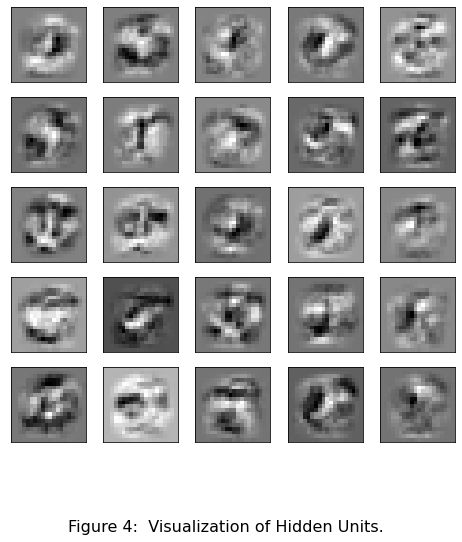

In [20]:
fig,ax_array = plt.subplots(nrows=5,ncols=5,sharex=True,sharey=True,figsize=(8,8))
theta,_ = deSerialization(res.x)
theta = theta[1:,:].T    # 去掉第一行
for i in range(25):
    r = i // 5
    c = i - r * 5   

    img = theta[i,:]
    img = img.reshape(20,20).T

    ax_array[r,c].imshow(img,cmap='gray')
plt.xticks(np.array([]))
plt.yticks(np.array([]))
fig.suptitle("Figure 4:  Visualization of Hidden Units.",fontsize=16,y = -0.01)

## 3.1 Optional (ungraded) exercise

精确度越高并不代表拟合的越好，别忘记还有"过拟合" 的情况

In [21]:
lambda_var = [0,1,3,0.1,0.3,0.01,0.03]
for i in range(len(lambda_var)):
    res = opt.minimize(fun=regularizedCost,x0=thetas,args=(X,Y,lambda_var[i]), method='TNC',jac=regularizedNN,options={'maxiter': 400})
    print("when lambda is "+str(lambda_var[i]))
    printAccuracy(res.x,X,Y)
    print("\n")

/home/mikasalee/anaconda3/envs/CourseraMLAndrewNgmyNoteEnv/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/home/mikasalee/anaconda3/envs/CourseraMLAndrewNgmyNoteEnv/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


when lambda is 0
accuracy：0.9982


when lambda is 1
accuracy：0.931


when lambda is 3
accuracy：0.9026


when lambda is 0.1
accuracy：0.9906


when lambda is 0.3
accuracy：0.9688


when lambda is 0.01
accuracy：1.0


when lambda is 0.03
accuracy：1.0




# END